In [1]:
# low is under bb_l, volume greater, green k and red k
# start time - 1609459200000, 1641028611000, 1672564611000, 1654045261000, 1651366861000 (2021, 2022, 2023)
# start_time = 1635743450000 2021/11
# end_time = 1654060250000 2022/6 BEAR

In [2]:
# ! conda install -c conda-forge ta --yes

In [3]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time
import os

In [4]:
timezone = 8
symbol = 'ethusdt'
interval = '1h'

# start epoch till now
start_time = 1635743450000
end_time = round(time.time() * 1000)
# end_time = 1654060250000

# step between timestamps in milliseconds
step = 60000 * 3600

In [5]:
from binance.client import Client
from dotenv import load_dotenv

# Get the path to the current directory
current_directory = os.getcwd()

# Specify the path to the .env file relative to the current directory
dotenv_path = os.path.join(current_directory, '.env')

# Load the environment variables from the .env file
load_dotenv(dotenv_path)

api_key = os.getenv('API_KEY')
api_secret = os.getenv('SECRET_KEY')

client = Client(api_key, api_secret, testnet = False)

In [6]:
sl_atr = 1
tp_atr = 2
kd_dir = 'Up'

In [7]:
def get_historical(symbol, interval, start_time, end_time, step):
        
#     url = "https://api.binance.com/api/v3/klines"

    # Fetch the data using batch requests
    data = []    
    while start_time < end_time:
        limit = min(step, end_time - start_time + 1)  # Adjust the limit for the last batch
        response = client.get_klines(symbol=symbol.upper(), interval=interval, limit=limit, startTime=start_time)

        if len(response) == 0:
            break  # No more data available, exit the loop
        data.extend(response)
        start_time = response[-1][0] + 1
    
    # Convert the data to a DataFrame
    columns = [
        "Open_Time", "Open", "High", "Low", "Close", "Volume", "Close_Time",
        "Quote asset volume", "Number of trades", "Taker buy base asset volume",
        "Taker buy quote asset volume", "Ignore"
    ]
    raw_df = pd.DataFrame(data, columns=columns)   
    
    raw_df = raw_df[['Open_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Open_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    raw_df = raw_df.astype(convert_dict)
    
    raw_df['Open_Time'] = pd.to_datetime(raw_df['Open_Time'], unit = 'ms')
    raw_df['Open_Time'] = raw_df['Open_Time'] + pd.Timedelta(hours=timezone)
    raw_df['Open_Time'] = raw_df['Open_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    raw_df = raw_df.reset_index(drop=True)
    
    return raw_df

In [8]:
loop_start_time = time.time()
raw_df = get_historical(symbol, interval, start_time, end_time, step)
loop_end_time = time.time()
print("Time taken to execute for loop:", loop_end_time - loop_start_time, "seconds")
print(raw_df)

Time taken to execute for loop: 2.3643932342529297 seconds
                 Open_Time     Open    Close     High      Low      Volume
0      2021-11-01 14:00:00  4225.00  4241.99  4259.14  4198.55  13908.9371
1      2021-11-01 15:00:00  4241.99  4302.93  4320.00  4241.46  31363.2190
2      2021-11-01 16:00:00  4302.94  4311.11  4338.07  4294.52  21038.5542
3      2021-11-01 17:00:00  4311.11  4316.56  4344.41  4310.64  16175.3592
4      2021-11-01 18:00:00  4316.55  4328.94  4335.00  4313.86  11207.7111
...                    ...      ...      ...      ...      ...         ...
13935  2023-06-05 06:00:00  1902.01  1901.61  1912.89  1899.09  24824.8307
13936  2023-06-05 07:00:00  1901.61  1890.01  1904.37  1885.00  23634.3715
13937  2023-06-05 08:00:00  1890.00  1882.12  1890.63  1875.67  20148.8753
13938  2023-06-05 09:00:00  1882.12  1884.25  1885.00  1875.45   9549.5727
13939  2023-06-05 10:00:00  1884.25  1886.14  1887.00  1883.37   2413.1207

[13940 rows x 6 columns]


In [9]:
df = raw_df.copy()

In [10]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down


def indicators(df, kd_dir):

# ema
    for i in (200, 500, 1000):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()        
        
# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    df['slow_k']= ta.momentum.stoch(df['High'], df['Low'], df['Close'], 17, 5)
    df['slow_d'] = ta.momentum.stoch_signal(df['High'], df['Low'], df['Close'], 17, 5)
    
# kd cross
    df['kd_cross'] = check_cross(df, kd_dir)

In [11]:
indicators(df, kd_dir)
print(df)

                 Open_Time     Open    Close     High      Low      Volume  \
0      2021-11-01 14:00:00  4225.00  4241.99  4259.14  4198.55  13908.9371   
1      2021-11-01 15:00:00  4241.99  4302.93  4320.00  4241.46  31363.2190   
2      2021-11-01 16:00:00  4302.94  4311.11  4338.07  4294.52  21038.5542   
3      2021-11-01 17:00:00  4311.11  4316.56  4344.41  4310.64  16175.3592   
4      2021-11-01 18:00:00  4316.55  4328.94  4335.00  4313.86  11207.7111   
...                    ...      ...      ...      ...      ...         ...   
13935  2023-06-05 06:00:00  1902.01  1901.61  1912.89  1899.09  24824.8307   
13936  2023-06-05 07:00:00  1901.61  1890.01  1904.37  1885.00  23634.3715   
13937  2023-06-05 08:00:00  1890.00  1882.12  1890.63  1875.67  20148.8753   
13938  2023-06-05 09:00:00  1882.12  1884.25  1885.00  1875.45   9549.5727   
13939  2023-06-05 10:00:00  1884.25  1886.14  1887.00  1883.37   2413.1207   

           ema_200      ema_500     ema_1000         bb_u      

In [12]:
def conditions(df):

    df['c1'] = df['Low'] <= df['bb_l']
    df['c2'] = df['Close'] > df['Open']
    df['c3'] = df['Close'] >= df['ema_1000']
    df['c4'] = df['Low'] <= df['ema_1000']

    # 條件達成
    df['signal'] = df.c1 & df.c2 & df.c3 & df.c4

    # 下一根進場
    df['open_entry'] = df['signal'].shift()
    
    return df

In [13]:
conditions(df)

,Open_Time,Open,Close,High,Low,Volume,ema_200,ema_500,ema_1000,bb_u,...,rsi,slow_k,slow_d,kd_cross,c1,c2,c3,c4,signal,open_entry
0,2021-11-01 14:00:00,4225.00,4241.99,4259.14,4198.55,13908.9371,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,True,False,False,False,NaN
1,2021-11-01 15:00:00,4241.99,4302.93,4320.00,4241.46,31363.2190,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,True,False,False,False,False
2,2021-11-01 16:00:00,4302.94,4311.11,4338.07,4294.52,21038.5542,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,True,False,False,False,False
3,2021-11-01 17:00:00,4311.11,4316.56,4344.41,4310.64,16175.3592,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,True,False,False,False,False
4,2021-11-01 18:00:00,4316.55,4328.94,4335.00,4313.86,11207.7111,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13935,2023-06-05 06:00:00,1902.01,1901.61,1912.89,1899.09,24824.8307,1878.534178,1859.804399,1853.027240,1910.237951,...,52.315855,44.713376,51.970582,False,False,False,True,False,False,False
13936,2023-06-05 07:00:00,1901.61,1890.01,1904.37,1885.00,23634.3715,1878.648365,1859.924981,1853.101132,1910.251349,...,37.833662,16.908539,44.681285,False,False,False,True,False,False,False
13937,2023-06-05 08:00:00,1890.00,1882.12,1890.63,1875.67,20148.8753,1878.682909,1860.013584,1853.159112,1910.927041,...,31.455430,16.555441,36.384629,False,True,False,True,False,False,False
13938,2023-06-05 09:00:00,1882.12,1884.25,1885.00,1875.45,9549.5727,1878.738303,1860.110336,1853.221231,1911.081310,...,34.658021,22.460439,29.496246,False,True,True,True,False,False,False


In [14]:
entry_df = conditions(df).copy()

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']
low_val = entry_df['Low']


for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_entry'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] + tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
        take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position and row['Close'] <= stop_loss:
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position and row['High'] >= take_profit:
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan
        
entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_entry']) | (entry_df['position'] != '')]

print(entry_df)

                 Open_Time     Open    Close     High      Low      Volume  \
1      2021-11-01 15:00:00  4241.99  4302.93  4320.00  4241.46  31363.2190   
2      2021-11-01 16:00:00  4302.94  4311.11  4338.07  4294.52  21038.5542   
3      2021-11-01 17:00:00  4311.11  4316.56  4344.41  4310.64  16175.3592   
4      2021-11-01 18:00:00  4316.55  4328.94  4335.00  4313.86  11207.7111   
5      2021-11-01 19:00:00  4328.94  4315.00  4354.33  4303.48  25788.9658   
...                    ...      ...      ...      ...      ...         ...   
13935  2023-06-05 06:00:00  1902.01  1901.61  1912.89  1899.09  24824.8307   
13936  2023-06-05 07:00:00  1901.61  1890.01  1904.37  1885.00  23634.3715   
13937  2023-06-05 08:00:00  1890.00  1882.12  1890.63  1875.67  20148.8753   
13938  2023-06-05 09:00:00  1882.12  1884.25  1885.00  1875.45   9549.5727   
13939  2023-06-05 10:00:00  1884.25  1886.14  1887.00  1883.37   2413.1207   

           ema_200      ema_500     ema_1000         bb_u  ... 

In [15]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位 usdt
pos_size = 200

col = ['Open_Time', 'Open', 'Close', 'High', 'Low', 'atr', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size / pos.at[index, 'entry_p']
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'take_profit']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close']
#             for i in range(index -1, -1, -1):
#                 if pos.at[i, 'position'] == 'Buy':
#                     pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
#                 break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):

    if pos.loc[i, 'position'] in ['Stop', 'Sell']:
        
        # look out for the + sign
        total_amt = pos.loc[i, 'amt'] + np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Sell'
        # watch out for the + in total_amt += trading_fee
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Sell']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt += trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()


# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Buy':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Sell', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if -position_amt_sum > max_profit:
            max_profit = -position_amt_sum
            
        if -position_amt_sum < max_loss:
            max_loss = -position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass

# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade < 0:
        wins += 1
    elif trade > 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)


cumulative_values = []
cumulative_sum = 0

for value in agg_amts:
    cumulative_sum -= value
    cumulative_values.append(cumulative_sum)

max_drawdown = min(cumulative_values)
    
# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate],
          'Max_Drawdown': [round(max_drawdown,2)]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')


   Profit  Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0  -13.45  3.6        9.04    -10.34          2         400.0  -33.61%   

  Win_Rate  Max_Drawdown  
0   43.75%        -27.12  

              Open_Time     Open    Close     High      Low        atr  \
0   2022-02-10 23:00:00  3169.96  3209.91  3264.85  3157.03  48.931119   
1   2022-02-11 07:00:00  3115.82  3072.49  3120.00  3056.74  50.152345   
2   2022-02-17 00:00:00  3066.28  3080.65  3088.00  3044.03  31.114646   
3   2022-02-17 01:00:00  3080.65  3070.70  3085.62  3067.57  30.181457   
4   2022-02-17 03:00:00  3093.50  3169.28  3186.77  3081.89  35.759725   
5   2022-02-17 14:00:00  3068.91  3098.97  3105.89  3063.21  35.101770   
6   2022-02-17 18:00:00  3060.43  3049.71  3076.96  3037.85  40.120704   
7   2022-03-03 15:00:00  2914.21  2908.03  2920.81  2899.43  38.156247   
8   2022-03-03 23:00:00  2887.74  2828.00  2891.40  2816.35  38.578637   
9   2022-08-26 16:00:00  1660.56  1659.38  1667.42  1652

In [16]:
plt_df = pos[['Open_Time', 'position', 'amt']]

cumulative_sum = 0
agg_amts = []
stop_date = None

for index, row in plt_df.iterrows():
    if row['position'] == 'Buy':
        cumulative_sum += row['amt']
    elif row['position'] == 'Stop' or row['position'] == 'Sell':
        cumulative_sum += row['amt']
        stop_date = row['Open_Time']
        agg_amts.append((stop_date, cumulative_sum))
        cumulative_sum = 0

        
# Convert the list of tuples into a new dataframe
agg_df = pd.DataFrame(agg_amts, columns=['date', 'cumulative_sum'])
agg_df['cumulative_sum'] = agg_df['cumulative_sum'].apply(lambda x: -x)

print(agg_df['cumulative_sum'].sum())
print(agg_df)

-9.849999999999937
                   date  cumulative_sum
0   2022-02-11 07:00:00         -6.1521
1   2022-02-17 03:00:00          9.0369
2   2022-02-17 18:00:00         -1.2519
3   2022-03-03 23:00:00         -5.9172
4   2022-08-26 19:00:00         -3.7855
5   2022-08-26 23:00:00        -10.3415
6   2022-11-08 21:00:00         -4.2519
7   2022-12-15 21:00:00         -2.4655
8   2023-01-06 23:00:00          1.6808
9   2023-02-26 22:00:00          2.8478
10  2023-04-24 02:00:00         -1.9953
11  2023-04-24 08:00:00          2.7106
12  2023-04-27 08:00:00          6.0516
13  2023-05-07 09:00:00          3.9232
14  2023-05-08 10:00:00         -2.3767
15  2023-06-02 00:00:00          2.4367


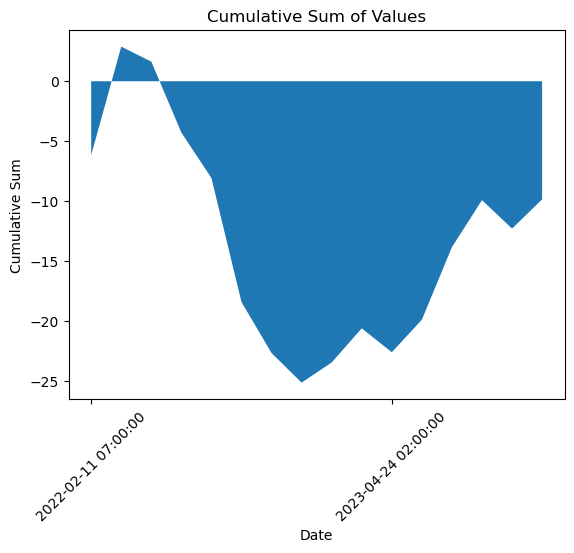

-27.116135649999975


In [19]:
cumulative_values = []
cumulative_sum = 0
for value in agg_df['cumulative_sum']:
    cumulative_sum += value
    cumulative_values.append(cumulative_sum)

plt.fill_between(agg_df['date'], cumulative_values, 0)

plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')


n = 10  # Adjust the value of n as per your preference
plt.xticks(agg_df['date'][::n], rotation=45)
plt.show()

print(max_drawdown)
# print(cumulative_values)

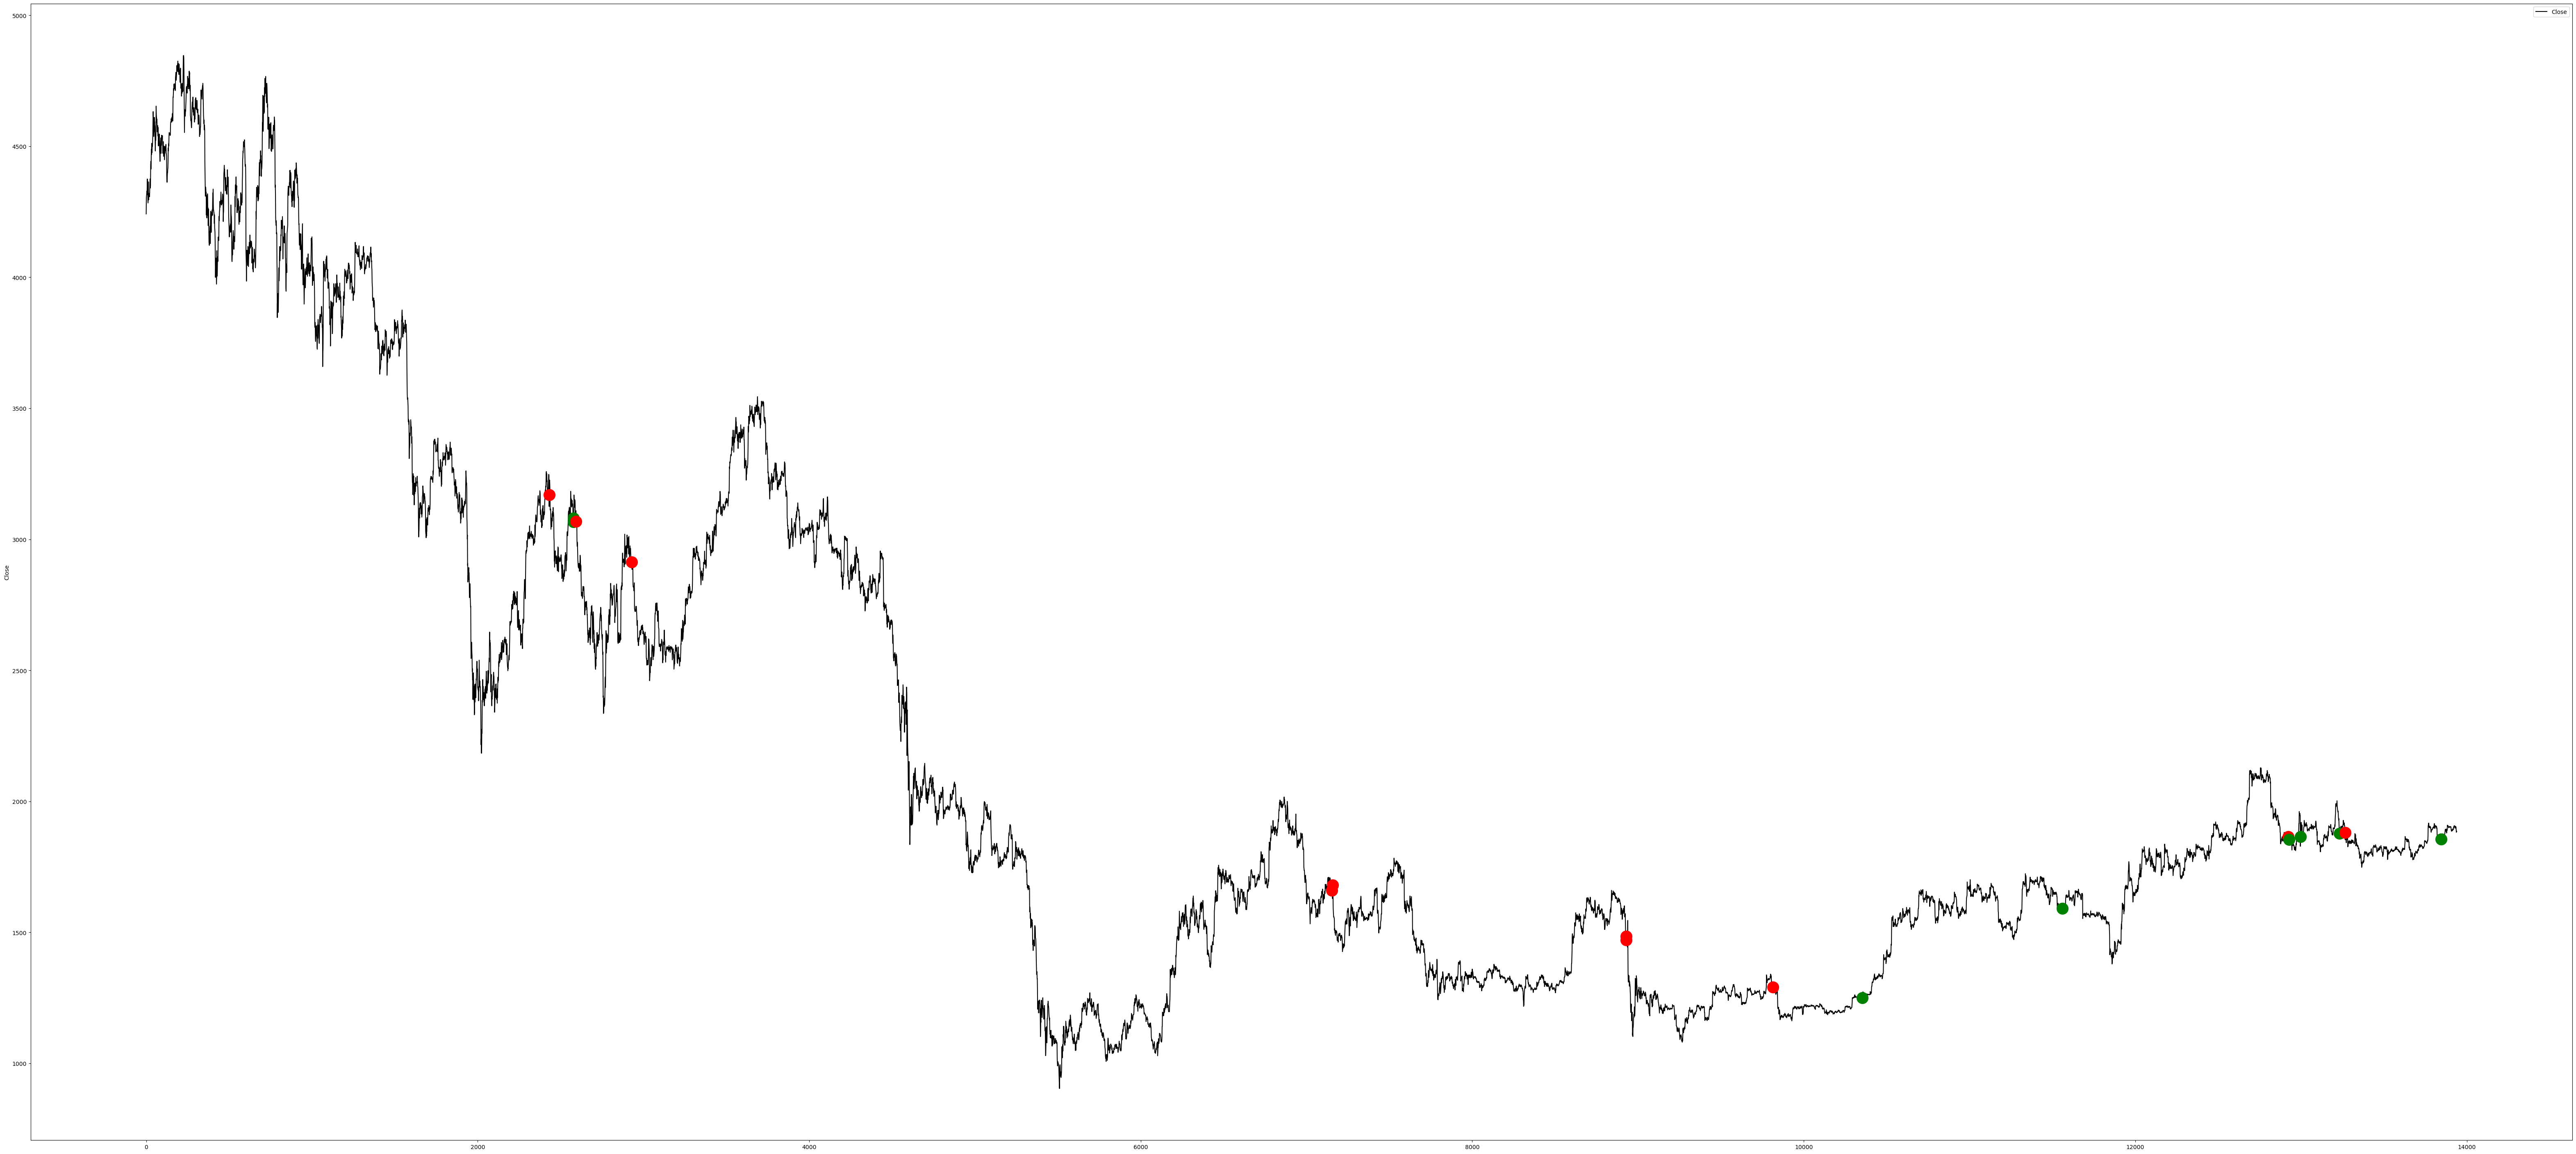

In [18]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位